<a href="https://colab.research.google.com/github/Ala-Mohamed/ASD-diagnosis-using-fMRI-A-computer-aided-approach-/blob/main/ML_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 19.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Best SVM Params: {'svm__C': 10, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
Best LR Params: {'lr__C': np.float64(0.001), 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

SVM Evaluation:
Accuracy: 0.6765, AUC: 0.8030, Precision: 0.7188, Recall: 0.6389, Specificity: 0.7188

Logistic Regression Evaluation:
Accuracy: 0.7206, AUC: 0.8238, Precision: 0.7742, Recall: 0.6667, Specificity: 0.7812


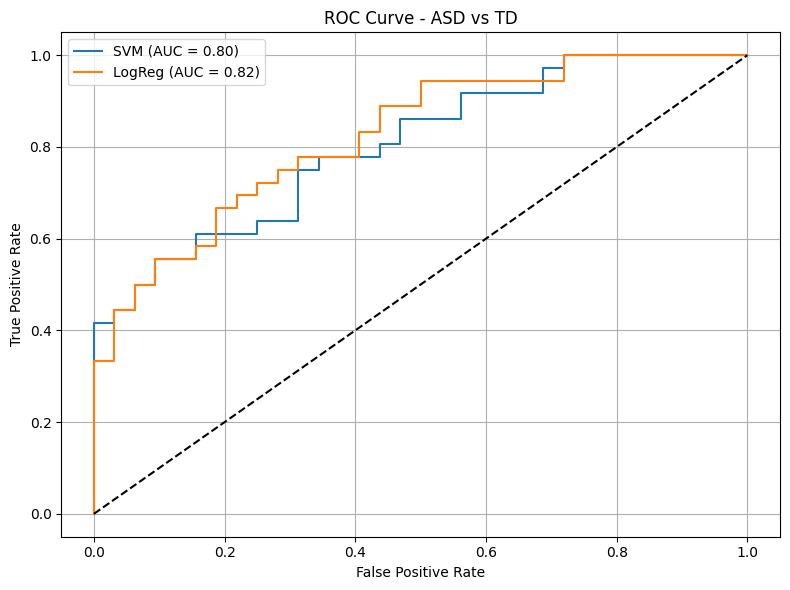

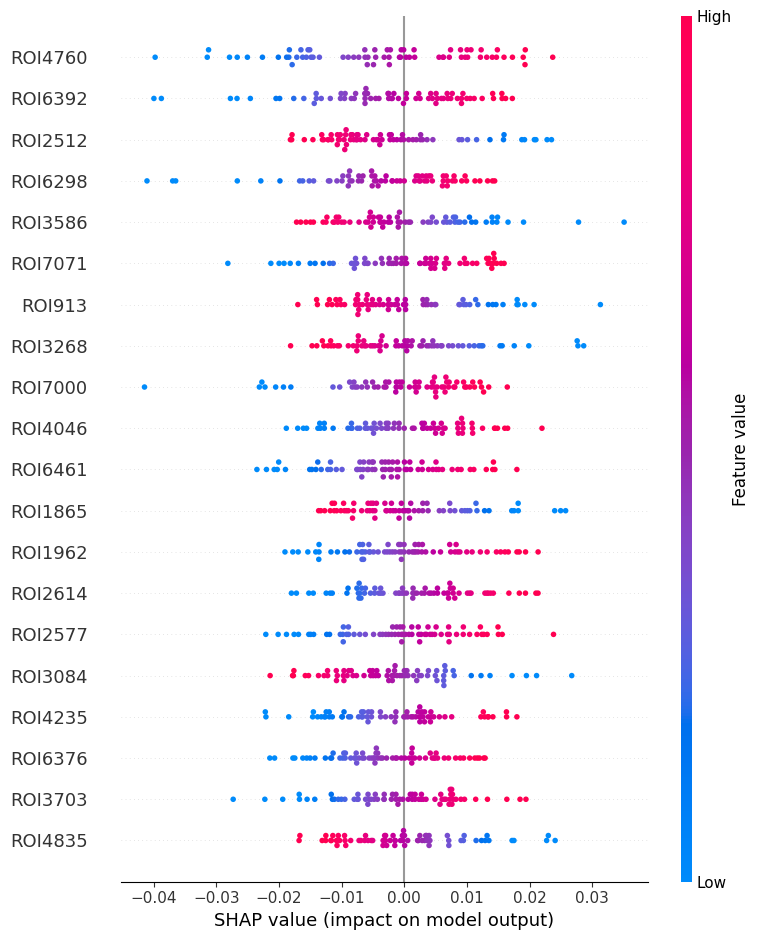

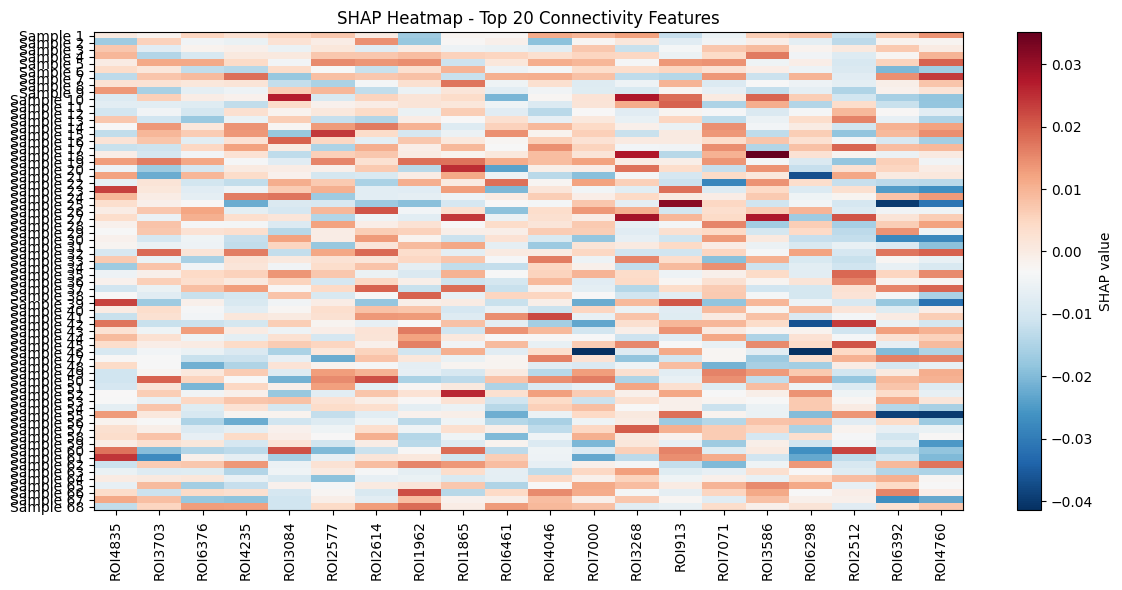

In [ ]:
import os
import glob
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ==== Load Data ====
asd_folder = '/content/drive/My Drive/matrices-bold-time-series/ASD'
td_folder = '/content/drive/My Drive/matrices-bold-time-series/HC'

asd_files = sorted(glob.glob(os.path.join(asd_folder, "*.csv")))
td_files = sorted(glob.glob(os.path.join(td_folder, "*.csv")))

asd_matrices = [np.genfromtxt(f, delimiter=',') for f in asd_files]
td_matrices = [np.genfromtxt(f, delimiter=',') for f in td_files]

np.random.seed(42)
n_subjects = 170

asd_subset = [asd_matrices[i] for i in np.random.choice(len(asd_matrices), n_subjects, replace=False)]
td_subset = [td_matrices[i] for i in np.random.choice(len(td_matrices), n_subjects, replace=False)]

all_matrices = asd_subset + td_subset
labels = np.array([1] * n_subjects + [0] * n_subjects)

# ==== Compute Spearman Connectivity ====
def compute_spearman_connectivity(ts):
    n_rois = ts.shape[1]
    mat = np.zeros((n_rois, n_rois))
    for i in range(n_rois):
        for j in range(i + 1, n_rois):
            corr, _ = spearmanr(ts[:, i], ts[:, j])
            mat[i, j] = corr
            mat[j, i] = corr
    return mat

connectivity_matrices = [compute_spearman_connectivity(m) for m in all_matrices]

# ==== Flatten to Upper Triangle ====
X = np.array([m[np.triu_indices(122, k=1)] for m in connectivity_matrices], dtype=np.float32)

# ==== Train/Test Split ====
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# ==== Pipeline (No PCA) ====
base_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_train = base_pipeline.fit_transform(X_train_raw)
X_test = base_pipeline.transform(X_test_raw)

# ==== SVM Grid Search ====
svm_param_grid = {
    'svm__kernel': ['rbf', 'linear'],
    'svm__gamma': [1e-3, 1e-4],
    'svm__C': [1, 10, 100]
}
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_raw, y_train)

# ==== Logistic Regression Grid Search ====
lr_param_grid = {
    'lr__C': np.logspace(-3, 3, 10),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear']
}
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_raw, y_train)

# ==== Evaluation ====
def evaluate(model, X_test, y_test, name="Model"):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, prob)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec = tn / (tn + fp)
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, Specificity: {spec:.4f}")
    return auc, prob

print("Best SVM Params:", svm_grid.best_params_)
print("Best LR Params:", lr_grid.best_params_)

auc_svm, svm_probs = evaluate(svm_grid.best_estimator_, X_test_raw, y_test, "SVM")
auc_lr, lr_probs = evaluate(lr_grid.best_estimator_, X_test_raw, y_test, "Logistic Regression")

# ==== ROC Curve ====
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {auc_lr:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ASD vs TD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== SHAP Analysis (Logistic Regression) ====
model = lr_grid.best_estimator_.named_steps['lr']
X_train_shap = base_pipeline.fit_transform(X_train_raw)
X_test_shap = base_pipeline.transform(X_test_raw)

explainer = shap.Explainer(model, X_train_shap)
shap_values = explainer(X_test_shap)

